In [ ]:
!pip install -qU langchain-core langchain-openai langchain_huggingface langchain-community langsmith

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.3/386.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
!pip install -qU faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 75.3 MB/s eta 0:00:00


In [ ]:
!pip install -qU langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 17.2 MB/s eta 0:00:00


In [ ]:
!pip install rank_bm25

# imports

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import os
from google.colab import userdata
import os
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from uuid import uuid4
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import MessagesState
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain import hub
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
from langchain.agents import load_tools
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from functools import partial
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage , AIMessage
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from IPython.display import Image, display,Markdown

In [ ]:
os.environ["GITHUB_TOKEN"] = userdata.get("GITHUB_TOKEN")

In [ ]:
os.environ['SERPER_API_KEY'] = userdata.get('SERPER_API_KEY')

In [ ]:
model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=1,
    max_tokens=4096,
    openai_api_base="https://models.inference.ai.azure.com",
    api_key=os.getenv("GITHUB_TOKEN"),
)

In [ ]:
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"

embedding_llm = HuggingFaceEmbeddings(model_name=model_name)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
embedding_dim = len(embedding_llm.embed_query("hello world"))
index = faiss.IndexFlatL2(embedding_dim)

vector_store = FAISS(
    embedding_function=embedding_llm,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

In [ ]:
def add_documents_to_vdb(url, vector_store):
    try:
        docs = WebBaseLoader(url).load()
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=100, chunk_overlap=50
        )
        doc_chunks = text_splitter.split_documents(docs)
        uuids = [str(uuid4()) for _ in range(len(doc_chunks))]
        vector_store.add_documents(documents=doc_chunks, ids=uuids)
        dense_retriever = vector_store.as_retriever(k=5)
        bm25_retriever = BM25Retriever.from_documents(doc_chunks)
        bm25_retriever.k = 8
        hybrid_retriever = EnsembleRetriever(
            retrievers=[bm25_retriever, dense_retriever],
            weights=[0.4, 0.6]
        )
        return hybrid_retriever
    except Exception as e:
        print(f"Error adding documents: {str(e)}")
        return False

In [ ]:
url = ["https://lilianweng.github.io/posts/2023-06-23-agent/",
       "https://lilianweng.github.io/posts/2025-05-01-thinking/",
       "https://lilianweng.github.io/posts/2024-07-07-hallucination/"
       ]

In [ ]:
hybrid_retriever = add_documents_to_vdb(url, vector_store)
retriever_tool = create_retriever_tool(
        hybrid_retriever,
        "retrieve_blog_posts",
        "Search and return information about blog posts on LLMs, LLM agents, prompt engineering, and adversarial attacks on LLMs.",
    )

In [ ]:
tools = [retriever_tool]

In [ ]:
add_documents_to_vdb(url, vector_store)

EnsembleRetriever(retrievers=[BM25Retriever(vectorizer=<rank_bm25.BM25Okapi object at 0x7bb7f5575820>, k=8), VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7bb817017110>, search_kwargs={})], weights=[0.4, 0.6])

In [ ]:
retrieved_chunks = hybrid_retriever.get_relevant_documents("What's Agent System Overview?")

In [ ]:
retrieved_chunks[0].page_content


'Agent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'

In [ ]:
class CustomState(TypedDict):
    messages: Annotated[list, add_messages]
    rewrite_count: int
    summary: str

In [ ]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(model="gpt-4o-mini",openai_api_base="https://models.inference.ai.azure.com",api_key=os.getenv("GITHUB_TOKEN"),)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a helpful assistant that checks if documents match user questions. \n
                  Here is the document: \n\n {context} \n\n
                  Here is the user question: {question} \n
                  Does this document help answer the question? \n
                  Reply with 'yes' if it helps answer the question, or 'no' if it does not help.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    # CHANGED: Find the last human question instead of always using messages[0]
    question = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content
            break
    if question is None:
        question = messages[0].content  # fallback to original logic

    docs = last_message.content
    current_count = state.get("rewrite_count", 0)

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    elif score == "no":
        if current_count >= 3:
            print(f"---DECISION: MAX REWRITES REACHED ({current_count}), GOING TO GOOGLE---")
            return "search_google"
        else:
            print(f"---DECISION: DOCS NOT RELEVANT, REWRITE ATTEMPT {current_count + 1}---")
            return "rewrite"

In [ ]:
def agent(state, tools):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    summary = state.get("summary", "")
    messages = state["messages"]
    if summary:
        system_message = f"""Summary of conversation earlier: {summary}

      NOTE: If the user asks about previous questions or conversation history, answer directly from this summary. For technical questions, use the retriever tool."""


        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    print("---CALL AGENT---")
    model = ChatOpenAI(model="gpt-4o-mini",openai_api_base="https://models.inference.ai.azure.com",api_key=os.getenv("GITHUB_TOKEN"),)
    model = model.bind_tools(tools)
    response = model.invoke(messages)

    return {"messages": [response]}

In [ ]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]

    question = None
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            question = msg.content
            break
    if question is None:
        question = messages[0].content

    current_count = state.get("rewrite_count", 0)
    new_count = current_count + 1
    print(f"---REWRITE ATTEMPT: {new_count}---")

    msg = [
        HumanMessage(
            content=f""" \n
                    Look at the input and try to reason about the underlying semantic intent / meaning. \n
                    Here is the initial question:
                    \n ------- \n
                    {question}
                    \n ------- \n
                    Formulate an improved question: """,
        )
    ]

    model = ChatOpenAI(model="gpt-4o-mini",openai_api_base="https://models.inference.ai.azure.com",api_key=os.getenv("GITHUB_TOKEN"),)
    response = model.invoke(msg)
    return {
        "messages": [response],
        "rewrite_count": new_count
    }

In [ ]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]

    # MAIN FIX: Find the last human question instead of always using messages[0]
    question = None
    for msg in reversed(messages):
        if hasattr(msg, 'content') and isinstance(msg, HumanMessage):
            question = msg.content
            break

    if question is None:
        question = messages[0].content  # fallback to original logic

    last_message = messages[-1]
    docs = last_message.content

    # Initialize a Chat Prompt Template
    prompt_template = hub.pull("rlm/rag-prompt")

    # Initialize a Generator (i.e. Chat Model)
    chat_model = ChatOpenAI(model="gpt-4o-mini",openai_api_base="https://models.inference.ai.azure.com",api_key=os.getenv("GITHUB_TOKEN"),)

    # Initialize a Output Parser
    output_parser = StrOutputParser()

    # RAG Chain
    rag_chain = prompt_template | chat_model | output_parser

    response = rag_chain.invoke({"context": docs, "question": question})

    return {"messages": [AIMessage(content=response)]}

In [ ]:
def search_google(state):
    """
    Search Google using the query stored in state["message"].
    Useful for searching recent or factual information from Google.
    """
    print("---SEARCH GOOGLE---")
    messages = state["messages"]
    query = messages[0].content
    tools = load_tools(["google-serper"])
    llm = ChatOpenAI(model="gpt-4o-mini",openai_api_base="https://models.inference.ai.azure.com",api_key=os.getenv("GITHUB_TOKEN"))
    agent = create_react_agent(llm, tools)
    response = agent.invoke({"messages": [("human", query)]})
    final_answer = response["messages"][-1].content
    return {
        "messages": [AIMessage(content=final_answer)],
        "rewrite_count": 0
    }

In [ ]:
def summarize_conversation(state):

    print("---start SUMMARIZE---")


    summary = state.get("summary", "")


    if summary:


        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"


    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)


    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-4]]
    return {"summary": response.content, "messages": delete_messages}

In [ ]:
def should_summarize(state):
    """
    Always return 'summarize' to ensure we always summarize at the end
    This function can be used if you want conditional summarization logic
    """
    print("---DECISION: PROCEEDING TO FINAL SUMMARIZATION---")

    """Return the next node to execute."""

    messages = state["messages"]


    if len(messages) > 10:
        return True

    return False

In [ ]:
def get_graph(retriever_tool):
    tools = [retriever_tool]  # Create tools list here

    # Define a new graph
    workflow = StateGraph(CustomState)

    # Use partial to pass tools to the agent function
    workflow.add_node("agent", partial(agent, tools=tools))

    # Rest of the graph setup remains the same
    retrieve = ToolNode(tools)
    workflow.add_node("retrieve", retrieve)
    workflow.add_node("search_google", search_google)
    workflow.add_node("rewrite", rewrite)
    workflow.add_node("summarize", summarize_conversation)
    workflow.add_node("generate", generate)
    workflow.add_edge(START, "agent")

    # Decide whether to retrieve
    workflow.add_conditional_edges(
        "agent",
        # Assess agent decision
        tools_condition,
        {
            "tools": "retrieve",
            END: END,
        },
    )

    # Edges taken after the `action` node is called.
    workflow.add_conditional_edges(
        "retrieve",
        # Assess agent decision
        grade_documents,
        {
        "rewrite": "rewrite",
        "generate": "generate",
        "search_google": "search_google",
    },
    )

    workflow.add_conditional_edges(
        "generate",
        # Assess agent decision
        should_summarize,
        {
            True: "summarize",
            False: END,
        },
    )

    workflow.add_edge("search_google", "generate")
    workflow.add_edge("summarize", END)
    workflow.add_edge("rewrite", "agent")



    # Compile
    within_thread_memory = MemorySaver()
    graph = workflow.compile(checkpointer=within_thread_memory)

    return graph

In [ ]:
graph = get_graph(retriever_tool)

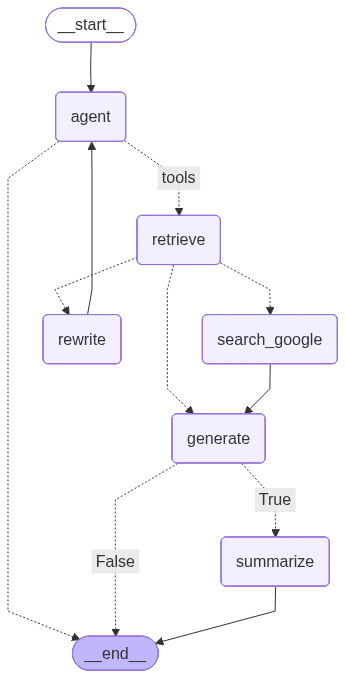

In [ ]:
graph

In [ ]:
def equations(query):
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}
config = {"configurable": {"thread_id": "1"}}
output = graph.invoke(inputs,config)
return output['messages'][-1].content

In [ ]:
query = "What is GPT-5 architecture?"
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}

In [ ]:
config = {"configurable": {"thread_id": "1"}}
output = graph.invoke(inputs,config)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT, REWRITE ATTEMPT 1---
---TRANSFORM QUERY---
---REWRITE ATTEMPT: 1---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT, REWRITE ATTEMPT 2---
---TRANSFORM QUERY---
---REWRITE ATTEMPT: 2---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT, REWRITE ATTEMPT 3---
---TRANSFORM QUERY---
---REWRITE ATTEMPT: 3---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: MAX REWRITES REACHED (3), GOING TO GOOGLE---
---SEARCH GOOGLE---
---GENERATE---
---DECISION: PROCEEDING TO FINAL SUMMARIZATION---
---start SUMMARIZE---


In [ ]:
from pprint import pprint
for m in output['messages']:
  pprint(m)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s4SCsaYc1N0xEEZYzIPgAmf3', 'function': {'arguments': '{"query":"GPT-5 enhancements features improvements"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2388, 'total_tokens': 2409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CJvGjM1VSa8fUTRb7CN6EwW7QodLF', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1f7a65fa-f77b-4ed2-881b-07f097c63c7e-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'GPT-5 enhancements features improvements'}, 'id': 'call_s4SCsaYc1N0xEEZYzIPgAmf3', 'type': 'tool_call'}], usage_metadata={'i

In [ ]:
output['messages'][-1].content

'GPT-5 is a multimodal large language model developed by OpenAI, characterized by its unified architecture that intelligently routes user requests and enhances performance across various tasks. It features improved reasoning capabilities, better instruction following, and a router mechanism that directs queries to specialized subnetworks for optimized responses. Additionally, GPT-5 can process multiple input types, such as text and voice, enhancing its versatility.'

In [ ]:
graph.get_state(config).values.get("summary","")

'In the conversation, the user inquired about the architecture and advancements of GPT-5 compared to its predecessors. The assistant provided an overview of GPT-5 as a multimodal large language model developed by OpenAI. Key features highlighted include its unified architecture that allows for intelligent routing of user requests, enhanced reasoning and instruction following capabilities, multimodal processing (text and voice), a router mechanism for optimized responses through specialized subnetworks, and targeted development aimed at improving collaboration on complex projects. Overall, these advancements represent a significant leap in the capabilities of generative pre-trained transformer models.'

In [ ]:
query = "What's Agent System Overview?"
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}
output = graph.invoke(inputs,config)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
---DECISION: PROCEEDING TO FINAL SUMMARIZATION---


In [ ]:
from pprint import pprint
for m in output['messages']:
  pprint(m)

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_s4SCsaYc1N0xEEZYzIPgAmf3', 'function': {'arguments': '{"query":"GPT-5 enhancements features improvements"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 2388, 'total_tokens': 2409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CJvGjM1VSa8fUTRb7CN6EwW7QodLF', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--1f7a65fa-f77b-4ed2-881b-07f097c63c7e-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'GPT-5 enhancements features improvements'}, 'id': 'call_s4SCsaYc1N0xEEZYzIPgAmf3', 'type': 'tool_call'}], usage_metadata={'i

In [ ]:
output['messages'][-1].content

"Agent System Overview refers to the framework of a large language model (LLM)-powered autonomous agent system, which includes components such as planning, memory, and tool use. It highlights the LLM as the central controller for tasks like task decomposition, self-reflection, and using various types of memory. The system's design allows LLMs to act as effective problem solvers across diverse applications."

In [ ]:
graph.get_state(config).values.get("summary","")

'In the conversation, the user inquired about the architecture and advancements of GPT-5 compared to its predecessors. The assistant provided an overview of GPT-5 as a multimodal large language model developed by OpenAI. Key features highlighted include its unified architecture that allows for intelligent routing of user requests, enhanced reasoning and instruction following capabilities, multimodal processing (text and voice), a router mechanism for optimized responses through specialized subnetworks, and targeted development aimed at improving collaboration on complex projects. Overall, these advancements represent a significant leap in the capabilities of generative pre-trained transformer models.'

In [ ]:
query = "What's Task Decomposition?"
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}
output = graph.invoke(inputs,config)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
---DECISION: PROCEEDING TO FINAL SUMMARIZATION---
---start SUMMARIZE---


In [ ]:
from pprint import pprint
for m in output['messages']:
  pprint(m)

HumanMessage(content="What's Task Decomposition?", additional_kwargs={}, response_metadata={}, id='76441482-8d5d-406e-a4de-029600131b7c')
AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ThWzbVlkvCagSfmhOQ0yQxWn', 'function': {'arguments': '{"query":"Task Decomposition in LLMs"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2041, 'total_tokens': 2063, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CJvHtwQWIeZYRDcdbzlFhosp04rSS', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69647396-8cc4-419e-9b1b-d38094f421d5-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '

In [ ]:
output['messages'][-1].content

'Task decomposition is the process of breaking down complex tasks into smaller, manageable steps or subgoals, which can be achieved through various methods, such as prompting a large language model (LLM) or using specific instructions. This approach enhances the model\'s performance by allowing it to "think step by step," effectively transforming larger tasks into simpler ones. It facilitates better planning and execution by clarifying the overall process and guiding the model’s reasoning.'

In [ ]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user inquired about the architecture and advancements of GPT-5 compared to its predecessors. The assistant provided an overview of GPT-5 as a multimodal large language model developed by OpenAI. Key features highlighted include its unified architecture that allows for intelligent routing of user requests, enhanced reasoning and instruction-following capabilities, multimodal processing (text and voice), a router mechanism for optimized responses through specialized subnetworks, and targeted development aimed at improving collaboration on complex projects. These advancements represent a significant leap in the capabilities of generative pre-trained transformer models.\n\nAdditionally, the user asked about the concept of Agent System Overview and Task Decomposition. The assistant explained that within a large language model (LLM)-powered autonomous agent system, the LLM acts as the brain, involving key components such as planning, memory, and tool use. Task decom

In [ ]:
query = "what is Component of Memory"
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}
output = graph.invoke(inputs,config)

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
---DECISION: PROCEEDING TO FINAL SUMMARIZATION---


In [ ]:
output['messages'][-1].content

'The components of memory include Long-Term Memory (LTM) and Short-Term Memory (STM). LTM can retain information for a long period, while STM holds information temporarily for immediate tasks, typically lasting 20-30 seconds. Each type has distinct functions and capacities relevant to cognitive processes.'

In [ ]:
from pprint import pprint
for m in output['messages']:
  pprint(m)

HumanMessage(content="What's Task Decomposition?", additional_kwargs={}, response_metadata={}, id='76441482-8d5d-406e-a4de-029600131b7c')
AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ThWzbVlkvCagSfmhOQ0yQxWn', 'function': {'arguments': '{"query":"Task Decomposition in LLMs"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2041, 'total_tokens': 2063, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CJvHtwQWIeZYRDcdbzlFhosp04rSS', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69647396-8cc4-419e-9b1b-d38094f421d5-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '

In [ ]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user inquired about the architecture and advancements of GPT-5 compared to its predecessors. The assistant provided an overview of GPT-5 as a multimodal large language model developed by OpenAI. Key features highlighted include its unified architecture that allows for intelligent routing of user requests, enhanced reasoning and instruction-following capabilities, multimodal processing (text and voice), a router mechanism for optimized responses through specialized subnetworks, and targeted development aimed at improving collaboration on complex projects. These advancements represent a significant leap in the capabilities of generative pre-trained transformer models.\n\nAdditionally, the user asked about the concept of Agent System Overview and Task Decomposition. The assistant explained that within a large language model (LLM)-powered autonomous agent system, the LLM acts as the brain, involving key components such as planning, memory, and tool use. Task decom

In [ ]:
query = "need all i asked before to you and need this in list of points "
inputs = {"messages": [HumanMessage(content=query)],
          "rewrite_count": 0}
output = graph.invoke(inputs,config)

---CALL AGENT---


In [ ]:
display(Markdown(output['messages'][-1].content))

Here’s a summary of the information you've inquired about, formatted as a list of points:

### GPT-5 Architecture and Advancements:
1. **Multimodal Large Language Model:** Developed by OpenAI.
2. **Unified Architecture:** Allows for intelligent routing of user requests.
3. **Enhanced Reasoning:** Improved instruction-following capabilities.
4. **Multimodal Processing:** Capable of handling both text and voice.
5. **Router Mechanism:** Optimizes responses through specialized subnetworks.
6. **Targeted Development:** Aimed at enhancing collaboration on complex projects.
7. **Significant Leap in Capabilities:** Represents an advancement over previous generative pre-trained transformer models.

### Agent System Overview and Task Decomposition:
1. **LLM as the Brain:** The model acts as the central processing unit in the agent system.
2. **Essential Components:**
   - **Planning:** Identifies and organizes necessary steps to complete tasks.
   - **Memory:** Stores, retains, and retrieves information.
   - **Tool Use:** Utilization of tools for executing specialized tasks.
3. **Task Decomposition:**
   - **Definition:** Breaking down complex tasks into smaller, manageable steps.
   - **Techniques:**
     - Simple prompting (e.g., "Steps for XYZ.\n1.")
     - Task-specific instructions (e.g., "Write a story outline.")
     - Human inputs could also guide decomposition.
   - **Chain of Thought (CoT):** A prompting technique that encourages step-by-step reasoning.

### Components of Memory:
1. **Types of Memory:**
   - **Long-Term Memory (LTM):** Stores information for extended periods; essentially unlimited capacity.
     - Two subtypes: [Additional details not specified in the previous context]
   - **Short-Term Memory (STM) or Working Memory:** Holds information temporarily for cognitive tasks; capacity is about 7 items, lasting for 20-30 seconds.

If you have any further questions or need additional details, feel free to ask!

In [ ]:
from pprint import pprint
for m in output['messages']:
  pprint(m)

HumanMessage(content="What's Task Decomposition?", additional_kwargs={}, response_metadata={}, id='76441482-8d5d-406e-a4de-029600131b7c')
AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ThWzbVlkvCagSfmhOQ0yQxWn', 'function': {'arguments': '{"query":"Task Decomposition in LLMs"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2041, 'total_tokens': 2063, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1408}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_efad92c60b', 'id': 'chatcmpl-CJvHtwQWIeZYRDcdbzlFhosp04rSS', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--69647396-8cc4-419e-9b1b-d38094f421d5-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': '

In [ ]:
graph.get_state(config).values.get("summary","")

"In the conversation, the user inquired about the architecture and advancements of GPT-5 compared to its predecessors. The assistant provided an overview of GPT-5 as a multimodal large language model developed by OpenAI. Key features highlighted include its unified architecture that allows for intelligent routing of user requests, enhanced reasoning and instruction-following capabilities, multimodal processing (text and voice), a router mechanism for optimized responses through specialized subnetworks, and targeted development aimed at improving collaboration on complex projects. These advancements represent a significant leap in the capabilities of generative pre-trained transformer models.\n\nAdditionally, the user asked about the concept of Agent System Overview and Task Decomposition. The assistant explained that within a large language model (LLM)-powered autonomous agent system, the LLM acts as the brain, involving key components such as planning, memory, and tool use. Task decom